In [1]:
import rebound as rb
import reboundx as rbx
import celmech as cm
from matplotlib import pyplot as plt

In [2]:
import numpy as np

In [3]:
from celmech.nbody_simulation_utilities import get_simarchive_integration_results, set_time_step

Set initial resonance, Delta, and migration rate

In [4]:
jres,kres = 2,1
Delta0 = -0.0125
tau_a2 = 1e6

Initialize simulation

In [5]:
sim = rb.Simulation()
sim.add(m=1)
sim.add(m=1e-5,P = 1 )
sim.add(m=1e-5,P = (jres)/(jres-kres) * (1+Delta0) )
sim.move_to_com()

sim.integrator = 'whfast'
sim.ri_whfast.safe_mode = 0
set_time_step(sim,1/21.)

extras = rbx.Extras(sim)

mod = extras.load_operator("modify_orbits_direct")
extras.add_operator(mod)
sim.particles[2].params['tau_a'] = tau_a2

Choose integration time and number of outputs

In [6]:
Tfin = 1e4
Nout = 512

Nsteps_out = int(np.floor(Tfin/Nout/sim.dt))

Integrate, saving to simulation archive

In [7]:
sim.automateSimulationArchive("diverging_migration_{}to{}.sa".format(jres,jres-kres),step=Nsteps_out,deletefile=True)

sim.integrate(Tfin)

# celmech

Make a `PoincareHamiltonian` with MMR terms

In [8]:
sa = rb.SimulationArchive("diverging_migration_{}to{}.sa".format(jres,jres-kres))

sim0 = sa[0]
pvars = cm.Poincare.from_Simulation(sim0)
pham = cm.PoincareHamiltonian(pvars)

pham.add_MMR_terms(jres,kres,max_order=1)

/fs/lustre/cita/hadden/miniconda3/envs/celmech/lib/python3.11/site-packages/rebound-3.24.3-py3.11-linux-x86_64.egg/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Canonical transformation to resonant angles

In [9]:
from celmech.canonical_transformations import CanonicalTransformation

In [10]:
A = np.eye(pham.N_dof,dtype=int)

A[0,:3] = [kres-jres,jres,1]
A[1,:4] = [kres-jres,jres,0,1]
A[2,:4] = [kres-jres,jres,0,0]
A[3,:4] = [0,1,0,0]

In [11]:
ct = CanonicalTransformation.from_poincare_angles_matrix(pvars,A)
kam = ct.old_to_new_hamiltonian(pham,do_reduction=True)
ct_p2c = CanonicalTransformation.polar_to_cartesian(kam.full_qp_vars,[0,1])
kam_xy = ct_p2c.old_to_new_hamiltonian(kam)
ct_composite = CanonicalTransformation.composite([ct,ct_p2c])

kam_xy.H

                                                                                                                           
  C_{(2,-1,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅x₁   C_{(2,-1,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅
- ─────────────────────────────────────────────────────────────── - ───────────────────────────────────────────────────────
                       _______________                                                   _______________                   
                     ╲╱ \Lambda_{1,0} ⋅a_{2,0}                                         ╲╱ \Lambda_{2,0} ⋅a_{2,0}           
                                                                                                                           
                                                                                                                           
                                                                                                                           

       

Conserved quantities of the new Hamiltonian:

In [12]:
Pcons = [p for q,p in kam_xy.full_qp_pairs if p not in kam_xy.qp_vars]

for P in Pcons:
    display((P,ct_composite.new_to_old(P)))

⎛            2     2     2     2⎞
⎜          η₁    η₂    κ₁    κ₂ ⎟
⎜P₃, -Λ₁ - ─── - ─── - ─── - ───⎟
⎝           2     2     2     2 ⎠

(P₄, 2⋅Λ₁ + Λ₂)

⎛      2     2⎞
⎜    ρ₁    σ₁ ⎟
⎜P₅, ─── + ───⎟
⎝     2     2 ⎠

⎛      2     2⎞
⎜    ρ₂    σ₂ ⎟
⎜P₆, ─── + ───⎟
⎝     2     2 ⎠

## Integrate with dissipateive terms added

The equations of motion with dissipation will be

$$
\frac{d \eta_i}{dt}\bigg|_\mathrm{dis}  \approx -\left({\gamma_{e,i}} + \frac{\gamma_{a,i}}{4}\right)\eta_i \\
\frac{d \kappa_i}{dt}\bigg|_\mathrm{dis}  \approx -\left({\gamma_{e,i}} + \frac{\gamma_{a,i}}{4}\right)\kappa_i\\
\frac{d \Lambda_i}{dt}\bigg|_\mathrm{dis}  = -\frac{\gamma_{a,i}}{2}\Lambda_i
$$

where $\gamma_{a,i} = -1/\tau_{a,i}$ and $\gamma_{e,i} = -1/\tau_{e,i}$.

In [13]:
import sympy as sp
from sympy.simplify.fu import TR10

Dynamical variables for new equations of motion

In [14]:
dyvars = kam_xy.qp_vars + Pcons[:2]

In [15]:
gamma_a = sp.symbols("gamma_a(1:{})".format(pham.N),positive = True)
gamma_e = sp.symbols("gamma_e(1:{})".format(pham.N),positive = True)
gamma_Lmbda = [ ga / 2 for ga in gamma_a]
gamma_ecc_vars = [(ge +  ga / 4) for ga,ge in zip(gamma_a,gamma_e)]

gamma_vars = gamma_e + gamma_a 

The dissipative terms, expressed using the new variables, $\{X_i\}_{i=1}^{6}$, are given by 
$$
\frac{dX_i}{dt}\bigg|_\mathrm{dis} = \sum_{j}
    \frac{\partial X_i}{\partial{\eta_j}}\frac{d \eta_i}{dt}\bigg|_\mathrm{dis} + 
        \frac{\partial X_i}{\partial{\kappa_j}}\frac{d \kappa_i}{dt}\bigg|_\mathrm{dis} + 
            \frac{\partial X_i}{\partial{\Lambda_j}}\frac{d \Lambda_i}{dt}\bigg|_\mathrm{dis}
$$

In [16]:
etas = [pham.qp_vars[3*i + 1] for i in range(pham.N-1)]
kappas = [pham.qp_vars[3*i + 1 + pham.N_dof] for i in range(pham.N-1)]
Lambdas = [pham.qp_vars[3*i  + pham.N_dof] for i in range(pham.N-1)] 
fdis = sp.Matrix(np.zeros(len(dyvars),dtype=int))
for i,v in enumerate(dyvars):
    exprn = ct_composite.new_to_old(v)
    exprn = sp.simplify(TR10(exprn))
    for j in range(pham.N-1):
        fdis[i] += -gamma_ecc_vars[j] * sp.diff(exprn,etas[j]) * etas[j]
        fdis[i] += -gamma_ecc_vars[j] * sp.diff(exprn,kappas[j]) * kappas[j]
        fdis[i] += -gamma_Lmbda[j] * sp.diff(exprn,Lambdas[j]) * Lambdas[j] 
fdis = sp.simplify(ct_composite.old_to_new(fdis))
fdis

⎡                                        ⎛γₐ₁      ⎞                                     ⎤
⎢                                    -y₁⋅⎜─── + γₑ₁⎟                                     ⎥
⎢                                        ⎝ 4       ⎠                                     ⎥
⎢                                                                                        ⎥
⎢                                        ⎛γₐ₂      ⎞                                     ⎥
⎢                                    -y₂⋅⎜─── + γₑ₂⎟                                     ⎥
⎢                                        ⎝ 4       ⎠                                     ⎥
⎢                                                                                        ⎥
⎢                                        ⎛γₐ₁      ⎞                                     ⎥
⎢                                    -x₁⋅⎜─── + γₑ₁⎟                                     ⎥
⎢                                        ⎝ 4       ⎠                                     ⎥

The conservative terms are given by Hamilton's equations:

In [17]:
fcons = sp.Matrix(np.zeros(len(dyvars),dtype=int))
for i in range(kam_xy.N_dim):
    fcons[i] = kam_xy.flow.xreplace(pham.H_params)[i]

Lambidfy the new equtaions:

In [18]:
Ndim = len(dyvars)
full_flow = sp.lambdify(tuple(dyvars) + gamma_vars,fcons + fdis)
jac = sp.Matrix(Ndim,Ndim, lambda i,j: sp.diff((fcons + fdis)[i],dyvars[j]))
full_jac = sp.lambdify(tuple(dyvars) + gamma_vars,jac)

Integrate new equations using scipy:

In [19]:
from scipy.integrate import solve_ivp

In [20]:
## set up
y0 = np.array([kam_xy.full_qp[v] for v in dyvars])
Ngammas = np.zeros(4)
Ngammas[-1] = -1/tau_a2

f = lambda t,y: full_flow(*y,*Ngammas).reshape(-1)
Df = lambda t,y: full_jac(*y,*Ngammas)

In [21]:
## integrate

times = np.linspace(0,1e4,256)
soln = solve_ivp(f,(times[0],times[-1]),y0,method='Radau',t_eval=times,jac = Df)

Convert solution to orbital elements

In [22]:
vals = np.array(kam_xy.full_values)
indices = [kam_xy.full_qp_vars.index(v) for v in dyvars]
Delta,e1,e2 = np.zeros((3,len(soln.y.T)))
particles = pvars.particles
for i,yvec in enumerate(soln.y.T):
    vals[indices] = yvec
    pvars.values = ct_composite.new_to_old_array(vals)
    Delta[i] = (jres-kres) * particles[2].P/particles[1].P / jres - 1
    e1[i] =  particles[1].e
    e2[i] =  particles[2].e

Compare N-body and celmech

/fs/lustre/cita/hadden/miniconda3/envs/celmech/lib/python3.11/site-packages/rebound-3.24.3-py3.11-linux-x86_64.egg/rebound/simulation.py:1987: FutureWarning: sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead
  warnings.warn( "sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead", FutureWarning)


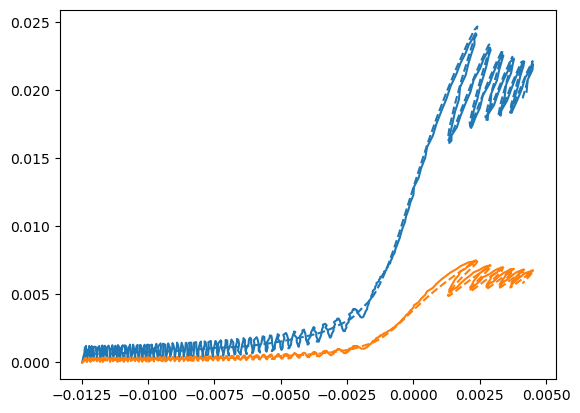

In [23]:
result = get_simarchive_integration_results("diverging_migration_{}to{}.sa".format(jres,jres-kres))
nbody_Delta = (jres-kres)*result['P'][1]/result['P'][0]/jres - 1 

l,=plt.plot(nbody_Delta,result['e'][0])
plt.plot(Delta,e1,color=l.get_color(),ls='--')
l,=plt.plot(nbody_Delta,result['e'][1])
plt.plot(Delta,e2,color=l.get_color(),ls='--')
